In [93]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [94]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [103]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

def get_average_protein_no_delta(path, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    #tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [71]:
!mkdir ../yaml/jan-15-2024
!mkdir ../output/jan-15-2024

In [ ]:
!mkdir ../yaml/jan-13-2024
!mkdir ../output/jan-13-2024

E. coli measurements:

- 2-10K mRNAs/cell
- 70K ribosomes/cell
- 375K tRNAs/cell

75-90% of ribosomes are bound to mRNAs

In [264]:
rcParams['figure.figsize'] = [5, 6]

/tmp/ipykernel_1418313/1653571807.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(['0', '0', '10K', '100K'])


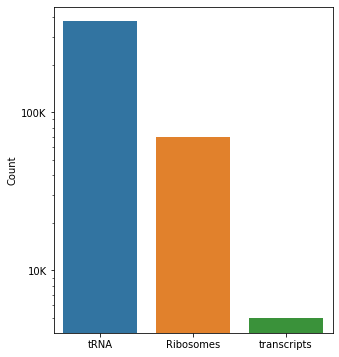

In [267]:
# Create a DataFrame with three values
data = {'Category': ['tRNA', 'Ribosomes', 'transcripts'],
        'E.coli': [375000, 70000, 5000],
        'Simulation': [1500, 300, 50]}
df = pd.DataFrame(data)


# Plot the DataFrame using seaborn
g = sns.barplot(x='Category', y='E.coli', data=df)
plt.yscale("log")
plt.xlabel("")
plt.ylabel("Count")
g.set_yticklabels(['0', '0', '10K', '100K'])

# Show the plot
plt.show()

/tmp/ipykernel_1418313/2355950647.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(['0', '0', '100', '1K'])


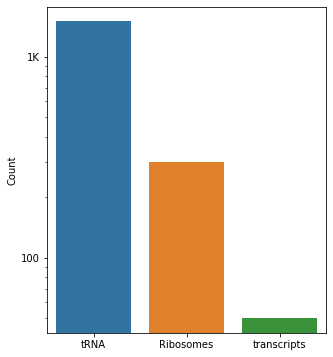

In [268]:
# Plot the DataFrame using seaborn
g = sns.barplot(x='Category', y='Simulation', data=df)
plt.yscale("log")
plt.xlabel("")
plt.ylabel("Count")
g.set_yticklabels(['0', '0', '100', '1K'])

# Show the plot
plt.show()

In [58]:
# simulation parameters 
# changing the species counts to better reflect actual cellular ratios
# also increased all RBS strengths by an order of magnitude
time_limit = 500
time_step = 5
transcript_lens = [900, 900]
cellular_transcript_copy_number = 40
transgene_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [1500.0, 10000.0, 15000.0, 100000.0, 150000.0, 1000000.0]
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.9, 0.1)]
codon_comps_2 = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 1
ribosome_footprint = 15

date = "jan-13-2024"

In [80]:
# simulation parameters 
# ribosome speed halved
time_limit = 500
time_step = 5
transcript_lens = [900, 900]
cellular_transcript_copy_number = 40
transgene_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [1500.0, 10000.0, 15000.0, 100000.0, 150000.0, 1000000.0]
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.9, 0.1)]
codon_comps_2 = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-15-2024"

In [76]:
for trna_prop in trna_props:
    for comp in codon_comps_2:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [77]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in transgene_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [81]:
ribosome_binding_rates = [1500.0, 10000.0, 15000.0, 100000.0, 150000.0, 1000000.0] + 
df_master = None

for copy_number in transgene_transcript_copy_number:
    df_copy = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in codon_comps_2:
            path = f"../output/{date}/two_codon_multi_transcript_0.9_0.1_{codons[0]}_{codons[1]}_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 500, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_copy is not None:
            df_copy = df_copy.append(df_binding, ignore_index=True)
        else:
            df_copy = df_binding
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 500.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_1418313/3925339351.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


In [90]:
#df_master[df_master.species == "free ribosome"]

In [91]:
df = df_master[(df_master.copy_number == 10)]
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df.pivot_table(index=['gfp_rbs', 'codon'], columns='species', values='protein')

In [41]:
rcParams['figure.figsize'] = [7, 4]

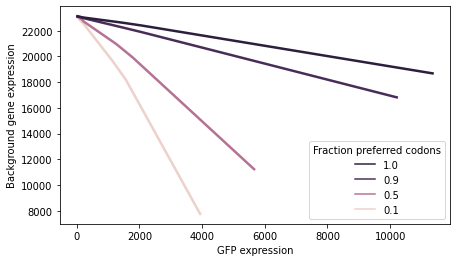

In [84]:
df
sns.lineplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", linewidth=2.5)
#plt.xscale("log")
plt.xlabel("GFP expression")
plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower right")

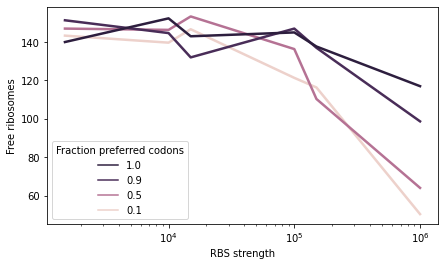

In [85]:
g = sns.lineplot(data=df, x = "gfp_rbs", y = "free ribosome", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("RBS strength")
plt.ylabel("Free ribosomes")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

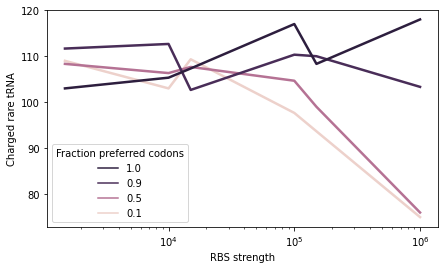

In [86]:
g = sns.lineplot(data=df, x = "gfp_rbs", y = "ATA_charged", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("RBS strength")
plt.ylabel("Charged rare tRNA")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

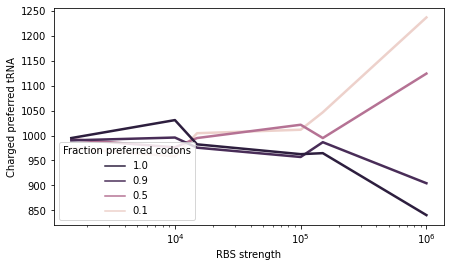

In [87]:
g = sns.lineplot(data=df, x = "gfp_rbs", y = "TTT_charged", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("RBS strength")
plt.ylabel("Charged preferred tRNA")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

In [101]:
# simulation parameters 
# ribosome speed halved
time_limit = 500
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = 10
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = 10.0
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.9, 0.1)
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_composition = (0.1, 0.9)
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-16-2024"

In [275]:
# simulation parameters 
# ribosome speed halved
time_limit = 500
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = 10
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = 10.0
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.9, 0.1)
ecol_mrna_composition = (0.7, 0.3) # less optimal e. coli codon compositions
gfp_mrna_composition = (0.1, 0.9)
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-16-2024-final"

In [273]:
!mkdir ../yaml/jan-16-2024-final
!mkdir ../output/jan-16-2024-final

mkdir: cannot create directory ‘../yaml/jan-16-2024-final’: File exists
mkdir: cannot create directory ‘../output/jan-16-2024-final’: File exists


In [276]:
serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, gfp_mrna_composition],
                                                       trna_proportion=trna_composition,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
serializer.serialize(f"../yaml/{date}")

In [277]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for seed in range(1, 4):
            cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
              f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {ribosome_binding_rates} {trna_charging_rate} {trna_charging_rate} " + \
              f"../output/{date} {ribosome_speed} {ribosome_footprint}"
            stream.write(cmd)
            stream.write("\n")

In [110]:
path = f"../output/{date}/two_codon_multi_transcript_0.9_0.1_0.1_0.9_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{ribosome_binding_rates}_{trna_charging_rate}_{trna_charging_rate}"
df = get_average_protein_no_delta(path, 200, 3)
df["species"] = df["species"].replace({"__ribosome": "free ribosome"})

In [111]:
df

,time,species,protein
0,0.0,ATA_charged,150.000000
1,0.0,ATA_uncharged,0.000000
2,0.0,TTT_charged,1350.000000
3,0.0,TTT_uncharged,0.000000
4,0.0,__GFP_rbs,10.000000
...,...,...,...
362,225.0,TTT_uncharged,480.000000
363,225.0,__GFP_rbs,10.000000
364,225.0,__cellularProtein_rbs,49.333333
365,225.0,free ribosome,91.666667


In [126]:
data = df[(df.species == 'TTT_charged') | (df.species == 'ATA_charged') | (df.species == 'free ribosome')]
species_totals = {"free ribosome": ribosome_copy_number,
                 "TTT_charged": total_trna*trna_composition[0],
                 "ATA_charged": total_trna*trna_composition[1]}
totals = [species_totals[name] for name in data["species"]]
data["percent total"] = data.protein / totals

/tmp/ipykernel_1418313/416115677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["percent total"] = data.protein / totals


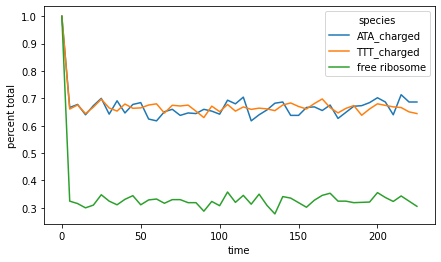

In [127]:
rcParams['figure.figsize'] = [7, 4]
g = sns.lineplot(data=data, x="time", y="percent total", hue="species")
#n = analytical_rib(rate, 3)
#plt.gca().axhline(n, ls='--', color="black", alpha=0.5)

In [132]:
# simulation parameters 
# ribosome speed halved
time_limit = 100
time_step = 5
transcript_lens = [1200, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = 10
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = 10.0
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.9, 0.1)
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_composition = (0.1, 0.9)
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-16-b-2024"

In [131]:
!mkdir ../yaml/jan-16-b-2024
!mkdir ../output/jan-16-b-2024

In [133]:
serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, gfp_mrna_composition],
                                                       trna_proportion=trna_composition,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
serializer.serialize(f"../yaml/{date}")

In [134]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for seed in range(1, 4):
            cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
              f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {ribosome_binding_rates} {trna_charging_rate} {trna_charging_rate} " + \
              f"../output/{date} {ribosome_speed} {ribosome_footprint}"
            stream.write(cmd)
            stream.write("\n")

In [278]:
path = f"../output/{date}/two_codon_multi_transcript_0.7_0.3_0.1_0.9_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{ribosome_binding_rates}_{trna_charging_rate}_{trna_charging_rate}"
df = get_average_protein_no_delta(path, 100, 3)
df["species"] = df["species"].replace({"__ribosome": "free ribosome"})

In [279]:
data = df[(df.species == 'TTT_charged') | (df.species == 'ATA_charged') | (df.species == 'free ribosome')]
species_totals = {"free ribosome": ribosome_copy_number,
                 "TTT_charged": total_trna*trna_composition[0],
                 "ATA_charged": total_trna*trna_composition[1]}
totals = [species_totals[name] for name in data["species"]]
data["percent total"] = data.protein / totals

/tmp/ipykernel_1418313/416115677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["percent total"] = data.protein / totals


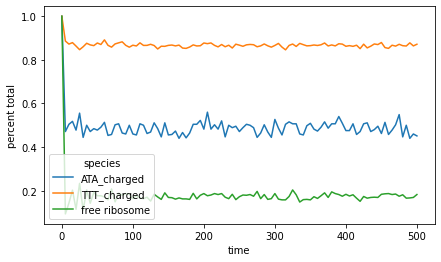

In [280]:
rcParams['figure.figsize'] = [7, 4]
g = sns.lineplot(data=data, x="time", y="percent total", hue="species")
#n = analytical_rib(rate, 3)
#plt.gca().axhline(n, ls='--', color="black", alpha=0.5)

In [140]:
# simulation parameters 
# ribosome speed halved
time_limit = 100
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = 10
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = 10.0
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.9, 0.1)
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_composition = (0.1, 0.9)
ribosome_speed = 0.1
ribosome_footprint = 15

date = "jan-16-c-2024"

In [139]:
!mkdir ../yaml/jan-16-c-2024
!mkdir ../output/jan-16-c-2024

In [141]:
serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, gfp_mrna_composition],
                                                       trna_proportion=trna_composition,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
serializer.serialize(f"../yaml/{date}")

In [142]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for seed in range(1, 4):
            cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
              f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {ribosome_binding_rates} {trna_charging_rate} {trna_charging_rate} " + \
              f"../output/{date} {ribosome_speed} {ribosome_footprint}"
            stream.write(cmd)
            stream.write("\n")

In [143]:
path = f"../output/{date}/two_codon_multi_transcript_0.9_0.1_0.1_0.9_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{ribosome_binding_rates}_{trna_charging_rate}_{trna_charging_rate}"
df = get_average_protein_no_delta(path, 100, 3)
df["species"] = df["species"].replace({"__ribosome": "free ribosome"})

In [144]:
data = df[(df.species == 'TTT_charged') | (df.species == 'ATA_charged') | (df.species == 'free ribosome')]
species_totals = {"free ribosome": ribosome_copy_number,
                 "TTT_charged": total_trna*trna_composition[0],
                 "ATA_charged": total_trna*trna_composition[1]}
totals = [species_totals[name] for name in data["species"]]
data["percent total"] = data.protein / totals

/tmp/ipykernel_1418313/416115677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["percent total"] = data.protein / totals


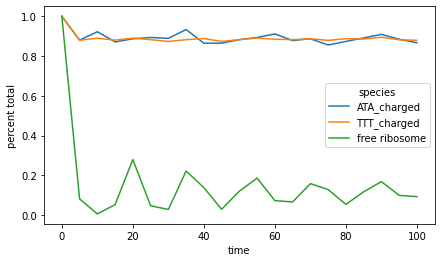

In [145]:
rcParams['figure.figsize'] = [7, 4]
g = sns.lineplot(data=data, x="time", y="percent total", hue="species")
#n = analytical_rib(rate, 3)
#plt.gca().axhline(n, ls='--', color="black", alpha=0.5)

In [166]:
# simulation parameters 
# ribosome speed halved
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10, 20, 50]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [100000.0, 150000.0, 1000000.0, 1500000.0, 10000000.0]
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_compositions = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-16-d-2024"

In [198]:
# simulation parameters 
# ribosome speed halved
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10, 20, 50]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [250000.0, 500000.0, 750000.0, 2500000.0, 7500000.0]
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.9, 0.1)
gfp_mrna_compositions = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-16-d-2024"

In [148]:
!mkdir ../yaml/jan-16-d-2024
!mkdir ../output/jan-16-d-2024

In [151]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [199]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in gfp_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [224]:
ribosome_binding_rates = [100000.0, 150000.0, 1000000.0, 1500000.0, 10000000.0, 250000.0, 500000.0, 750000.0, 2500000.0, 7500000.0]
df_master = None

for copy_number in gfp_transcript_copy_number:
    df_copy = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.9_0.1_{codons[0]}_{codons[1]}_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_copy is not None:
            df_copy = df_copy.append(df_binding, ignore_index=True)
        else:
            df_copy = df_binding
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)
df_master

,time,species,protein,delta,codon,gfp_rbs,copy_number
9,200.0,ATA_charged,100.000000,-2.000000,1.0,100000.0,10
10,200.0,ATA_uncharged,50.000000,2.000000,1.0,100000.0,10
11,200.0,GFP,404.000000,79.333333,1.0,100000.0,10
12,200.0,TTT_charged,881.333333,9.333333,1.0,100000.0,10
13,200.0,TTT_uncharged,468.666667,-9.333333,1.0,100000.0,10
...,...,...,...,...,...,...,...
2155,200.0,TTT_uncharged,7.000000,-8.000000,0.1,7500000.0,50
2156,200.0,__GFP_rbs,43.000000,0.666667,0.1,7500000.0,50
2157,200.0,__cellularProtein_rbs,50.000000,0.000000,0.1,7500000.0,50
2158,200.0,free ribosome,0.666667,0.000000,0.1,7500000.0,50


In [240]:
df = df_master[(df_master.copy_number == 50)]
df["gfp_rbs_foldx"] = df["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='protein')
df

/tmp/ipykernel_1418313/916239280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["gfp_rbs_foldx"] = df["gfp_rbs"] / ecol_rbs_rate


species              ATA_charged  ATA_uncharged           GFP  TTT_charged  \
gfp_rbs_foldx codon                                                          
1.0           0.1      65.333333      84.666667   4037.333333  1150.000000   
              0.5      78.666667      71.333333   5580.333333  1058.333333   
              0.9      96.000000      54.000000   8046.333333   838.333333   
              1.0     108.333333      41.666667   8700.000000   832.000000   
1.5           0.1      59.333333      90.666667   4624.000000  1175.000000   
              0.5      80.000000      70.000000   6774.333333  1123.666667   
              0.9      93.000000      57.000000  10939.000000   853.000000   
              1.0     112.333333      37.666667  12334.333333   792.000000   
2.5           0.1      60.000000      90.000000   5207.000000  1236.333333   
              0.5      66.000000      84.000000   8107.333333  1152.333333   
              0.9      95.333333      54.666667  15411.000000   876.000000   
              1.0     110.333333      39.666667  17988.000000   787.333333   
5.0           0.1      60.000000      90.000000   5752.000000  1280.333333   
              0.5      64.000000      86.000000   9470.000000  1161.000000   
              0.9      94.666667      55.333333  22263.666667   826.333333   
              1.0     116.333333      33.666667  27036.333333   702.000000   
7.5           0.1      59.666667      90.333333   5937.666667  1295.000000   
              0.5      66.333333      83.666667  10041.333333  1209.333333   
              0.9      98.666667      51.333333  26185.000000   812.000000   
              1.0     122.000000      28.000000  32484.000000   704.000000   
10.0          0.1      60.000000      90.000000   6058.666667  1315.000000   
              0.5      63.333333      86.666667  10341.666667  1226.000000   
              0.9      94.333333      55.666667  28671.000000   831.333333   
              1.0     131.333333      18.666667  36006.000000   649.333333   
15.0          0.1      57.333333      92.666667   6168.333333  1300.000000   
              0.5      61.666667      88.333333  10669.000000  1245.666667   
              0.9      90.666667      59.333333  31897.666667   801.333333   
              1.0     127.333333      22.666667  40307.333333   612.333333   
25.0          0.1      63.333333      86.666667   6260.333333  1330.666667   
              0.5      63.666667      86.333333  10944.333333  1250.666667   
              0.9      90.666667      59.333333  35028.333333   792.666667   
              1.0     134.000000      16.000000  44524.333333   591.666667   
75.0          0.1      66.000000      84.000000   6351.666667  1343.000000   
              0.5      61.333333      88.666667  11222.000000  1264.666667   
              0.9      87.666667      62.333333  38808.666667   800.333333   
              1.0     139.000000      11.000000  49756.000000   596.666667   
100.0         0.1      65.000000      85.000000   6366.000000  1334.333333   
              0.5      62.666667      87.333333  11267.333333  1253.333333   
              0.9      92.333333      57.666667  39382.000000   799.666667   
              1.0     140.666667       9.333333  50634.000000   570.666667   

species              TTT_uncharged  __GFP_rbs  __cellularProtein_rbs  \
gfp_rbs_foldx codon                                                    
1.0           0.1       200.000000  46.000000              50.000000   
              0.5       291.666667  48.333333              49.666667   
              0.9       511.666667  47.666667              48.666667   
              1.0       518.000000  49.000000              50.000000   
1.5           0.1       175.000000  45.666667              49.666667   
              0.5       226.333333  48.333333              49.666667   
              0.9       497.000000  47.333333              49.666667   
              1.0       558.000000  49.666667              49.000000   
2.5

In [241]:
df["TTT_charged"] = df["TTT_charged"] / 1350
df["ATA_charged"] = df["ATA_charged"] / 150
df["free ribosome"] = df["free ribosome"] / 300

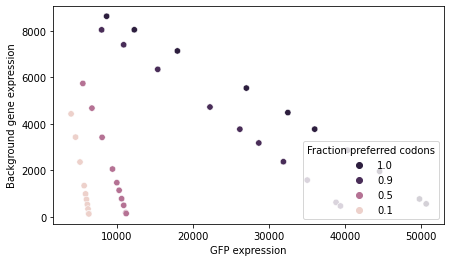

In [242]:
sns.scatterplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", s=40)
#plt.xscale("log")
plt.xlabel("GFP expression")
plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower right")

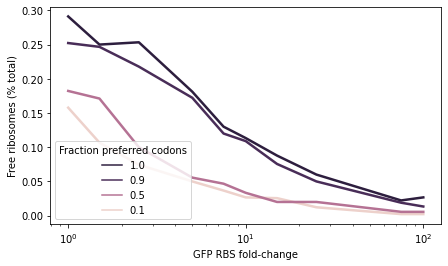

In [246]:
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "free ribosome", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Free ribosomes (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

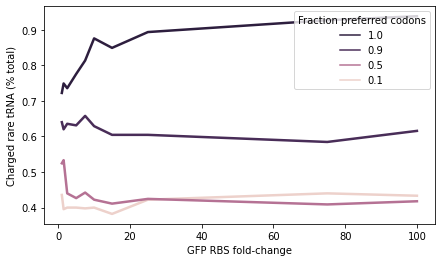

In [244]:
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "ATA_charged", hue = "codon", linewidth=2.5)
#plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Charged rare tRNA (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="upper right")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

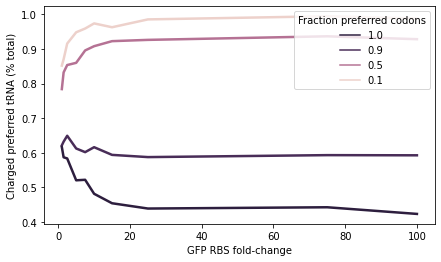

In [245]:
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "TTT_charged", hue = "codon", linewidth=2.5)
#plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Charged preferred tRNA (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="upper right")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])